In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import shelve
import numba as nb

In [2]:
@nb.njit()
def frk4_step(y,u0,umid,u1,h,w,K,F,N):
    k1 = h * Fkuramoto_nb( y, u0,w,K,F,N)
    k2 = h * Fkuramoto_nb(y + 0.5 * k1, umid,w,K,F,N)
    k3 = h * Fkuramoto_nb( y + 0.5 * k2, umid,w,K,F,N)
    k4 = h * Fkuramoto_nb(y + k3, u1, w,K,F,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))

@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(ut-x[i])
    return y

@nb.njit()
def whipeout(N, initlen, ut0,utmid,ut1, x0, h,w,p):
    uin, K,F= p[0],p[1], p[2] 
    for j in nb.prange(initlen):
        U0 = ut0[j]
        Umid = utmid[j]
        U1 = ut1[j]
        
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
    return x

@nb.njit()
def kura_run(N,runlen, ut0, utmid,ut1, x0, h,w,p):
    uin, K,F = p[0],p[1], p[2]
    X = np.empty((N,runlen))
    for j in nb.prange(runlen):
        U0 = ut0[j]
        Umid = utmid[j]
        U1 = ut1[j]
        
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
        X[:,j] = x
    return X

@nb.njit()
def nb_concatdot30( x, y): 
    res = 0
    for i in nb.prange(x.shape[0]):
        if i==0:
            res+=x[i]
        else:
            res+=x[i]*y[i-1]
    return res

@nb.njit()
def NMSE(yeval,ydata):
    nmse = 0
    for j in nb.prange(yeval.shape[0]):
        nmse += (ydata[j]-yeval[j])**2
    nmse=nmse/numba_norm(ydata)**2
    return nmse

@nb.njit() 
def numba_norm(a):
    n = a.shape[0]
    norm = 0
    for i in range(n):
        norm += a[i] * a[i]
    return np.sqrt(norm)

@nb.njit()
def varRK4(t, state, dt, f, p, Wout,w,N):
    tmid = t + dt*0.5
    k1 = dt*fkura_closed(t,state,p,Wout,w,N) 
    k2 = dt*fkura_closed(t,state + 0.5 * k1,p,Wout,w,N)
    k3 = dt*fkura_closed(t,state + 0.5 * k2,p,Wout,w,N) 
    k4 = dt*fkura_closed(t + dt ,state + k3,p,Wout,w,N)
    y= (state + (1.0/6.0) * (k1 + 2*k2 + 2*k3 + k4))
    return ( y % (2*math.pi))
    
@nb.njit()
def fkura_closed(t,x,p,Wout,w,N):   
    uin, K,F = p[0],p[1],p[2]    
    y = np.empty(N,dtype='float64')
    R1=0
    R2=0    
    Up0= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))   
    for i in nb.prange(N):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(N):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(Up0*uin-x[i])     
    return y

@nb.njit()
def concat_nb0(x,y):
    res = np.empty( (x.shape[0]+y.shape[0]), dtype = 'float64')
    for i in nb.prange(x.shape[0]+y.shape[0]):
        if i < x.shape[0]:
            res[i] = x[i]
        else:
            res[i] = y[i- x.shape[0] ]
    return res 

@nb.njit()
def solve(N,m, x0, p,Wout,u0, w , ydata,dt):
    X = np.zeros((N,m+1)) 
    U_pred = np.zeros((m+1))
    Up=u0
    X[:,0] = x0
    t=0 #dummy
    for i in range(0,m):
        t=dt+t
        X[:,i+1] = varRK4(t, X[:,i], dt, fkura_closed, p, Wout,w,N)
        xstate = concat_nb0(np.sin(X[:,i+1]), np.sin(X[:,i+1])**2)
        Up= nb_concatdot30(Wout, xstate)
        U_pred[i+1]= Up
    return  U_pred[1:], X[:,1:]

In [3]:
#load parameters and data

with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['mackey_glass'] 

# with shelve.open('D:/GitHub/kuramoto_reservoir/NoMultiplexing/RK4/performance_results/shelve/RK4_mg_sinsin2_new_stepping_40_att_2pop.shelve','r') as shelf:
#     p_dict= shelf['2nkdaqh2'][0]
    
with shelve.open('shelve/param.shelve', 'r') as shelf:
    p_dict = shelf['mackey_glass'] 

    
w=p_dict['w']
N = p_dict['N']
K,F,uin= p_dict['K'], p_dict['F'],  p_dict['uin']
p=np.array([uin, K,F]) 
initlen = p_dict['initlen']
trainlen = p_dict['trainlen']
testlen = p_dict['testlen']*5 #increasing a bit for autocorrelation
h = p_dict['h']
reg = p_dict['reg']


ut0 =data[::48]
utmid =data[24:][::48]
ut1 =data[48:][::48]


In [4]:
initlen

2200

Text(0, 0.5, 'testing')

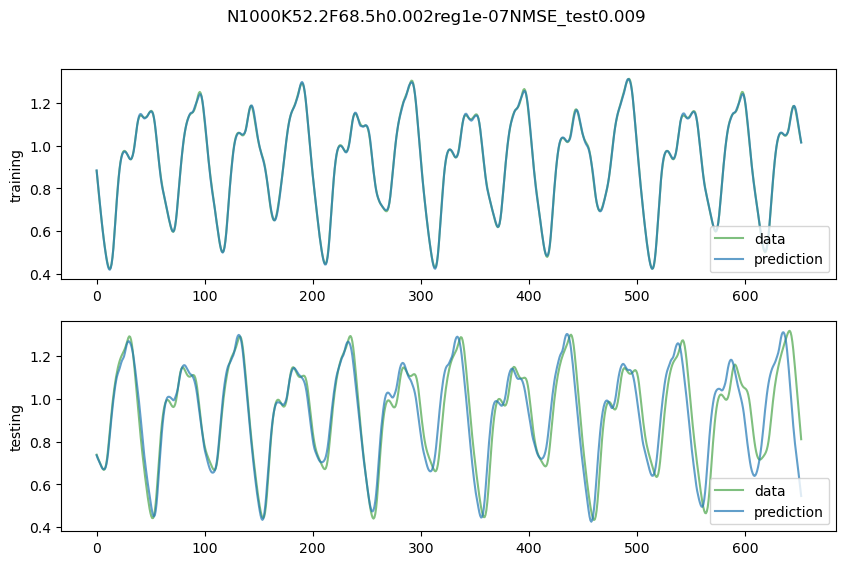

In [5]:
x=whipeout(N,initlen, ut0,utmid,ut1, np.linspace(0,2*math.pi,N), h, w,p) 
X0= kura_run(N,trainlen, ut0[initlen:],utmid[initlen:],ut1[initlen:], x,h,w,p)

X =  np.concatenate((np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0),np.sin(X0)**2),axis=0)
Yt =ut0[(initlen+1):(initlen+trainlen+1)].T

Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(2*N+1) , np.dot(X,Yt) ).T
pred = (Wout @ X)
nmse_train = NMSE(  np.dot(Wout,X), Yt.T)
u0 = Yt.T[-1] 
x0= X0[:,-1] 
ydata =ut0[initlen+trainlen+1:initlen+trainlen+testlen+1]
U_pred, X_pred = solve(N,testlen, x0, p, Wout,u0, w , ydata,h)

nmse_test = NMSE(U_pred[:800],ydata[:800])

fig, ax = plt.subplots(2, 1,figsize=(10,6))
fig.suptitle(f'N{N}K{K}F{F}h{h}reg{reg}NMSE_test{np.round(nmse_test,4)}')

ax[0].plot(np.arange(0,800)*((17/1000)*48), Yt[:800],label='data',alpha=0.5,color='green')
ax[0].plot(np.arange(0,800)*((17/1000)*48), pred[:800], label='prediction',alpha=0.7,c='C0')
ax[0].legend() 
ax[0].set_ylabel('training')
ax[1].plot(np.arange(0,800)*((17/1000)*48),ydata[:800],label = 'data', color='green',alpha=0.5)
ax[1].plot(np.arange(0,800)*((17/1000)*48),U_pred[:800],label='prediction', c='C0',alpha=0.7)
ax[1].legend()
ax[1].set_ylabel('testing')



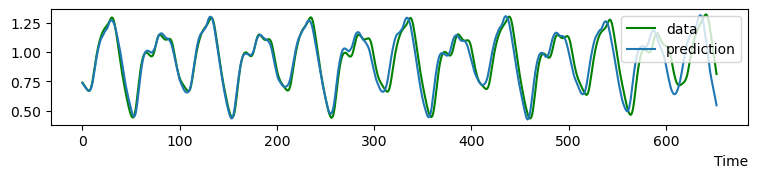

In [6]:
fig = plt.figure(figsize=(9,1.5))
plt.plot(np.arange(0,800)*((17/1000)*48),ydata[:800],label = 'data', color='green')
plt.plot(np.arange(0,800)*((17/1000)*48),U_pred[:800],label='prediction', c='C0')
plt.xlabel('Time', loc='right')
plt.legend(loc='upper right')
plt.savefig(f'pictures_paper/mk_glass.jpg',dpi=300,bbox_inches = 'tight')

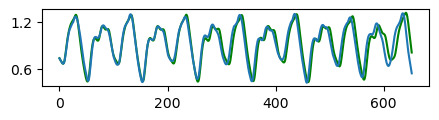

In [19]:
fig = plt.figure(figsize=(5,1))
plt.plot(np.arange(0,800)*((17/1000)*48),ydata[:800],label = 'data', color='green')
plt.plot(np.arange(0,800)*((17/1000)*48),U_pred[:800],label='prediction', c='C0')
#plt.xlabel('t', loc='right')
#plt.legend(loc='upper right')
plt.yticks([0.6,1.2])
plt.xticks([0,200,400,600])
plt.savefig(f'pictures_paper/mk_glass.jpg',dpi=300,bbox_inches = 'tight')

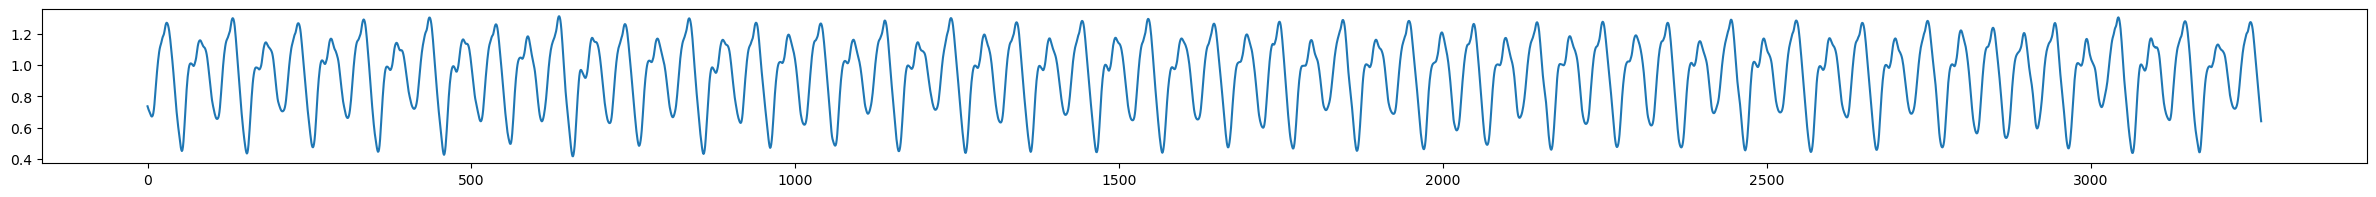

In [6]:
fig = plt.figure(figsize=(30,2))
plt.plot(np.arange(0,testlen)*((17/1000)*48), U_pred)

In [7]:
# autocorr check
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

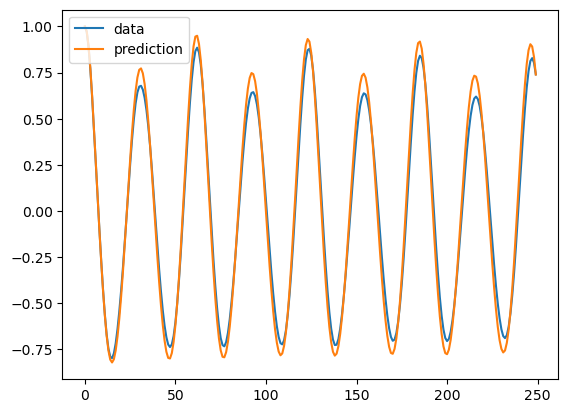

In [8]:
plt.plot(autocorr1(ydata,np.arange(0,500,2)), label='data')
plt.plot(autocorr1(U_pred,np.arange(0,500,2)), label='prediction')

plt.legend()

In [9]:
np.random.seed(0)

In [25]:
NMSE_list =[]
initlen=5000
testlen=1000
for _ in range(10):
    x=whipeout(N,initlen, ut0,utmid,ut1, (np.random.rand(N)*2*np.pi) % (2*np.pi), h, w,p) 
    X0= kura_run(N,trainlen, ut0[initlen:],utmid[initlen:],ut1[initlen:], x,h,w,p)

    X =  np.concatenate((np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0),np.sin(X0)**2),axis=0)
    Yt =ut0[(initlen+1):(initlen+trainlen+1)].T

    Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(2*N+1) , np.dot(X,Yt) ).T
    pred = (Wout @ X)
    nmse_train = NMSE(  np.dot(Wout,X), Yt.T)
    u0 = Yt.T[-1] 
    x0= X0[:,-1] 
    ydata =ut0[initlen+trainlen+1:initlen+trainlen+testlen+1]
    U_pred, X_pred = solve(N,testlen, x0, p, Wout,u0, w , ydata,h)

    nmse_test = NMSE(U_pred[:800],ydata[:800])
    NMSE_list.append(nmse_test)
    
print(np.mean(NMSE_list),np.std(NMSE_list))

0.011163256969679252 0.00814714658966711
